In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil

In [71]:
# Loads csv files and appends pixels to X and labels to y
def preprocess_data():
    data = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')
    labels = pd.read_csv('/kaggle/input/data-face/fer2013new.csv')

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48

    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 1))
    for i in range(n_samples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y

In [72]:
def clean_data_and_normalize(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown or NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y

In [73]:
def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

    # Split Data
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [74]:
def data_augmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen

In [75]:
def show_augmented_images(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
        # plt.xlabel(class_names[y_train[i]])
    plt.show()

In [76]:
def define_model(input_shape=(48, 48, 1), classes=7):
    
    num_features = 64

    model = Sequential()

    # 1st stage
    model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.5))

    # 2nd stage
    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 3rd stage
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    # 4th stage
    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 5th stage
    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    model.add(Flatten())

    # Fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))

    return model

In [77]:
def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0, 3.5])
    plt.legend(loc='upper right')
    plt.show()

In [78]:
def save_model_and_weights(model, test_acc):
    # Serialize and save model to JSON
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
    with open('/kaggle/working/model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Serialize and save weights to JSON
    model.save_weights('/kaggle/working/model' + str(test_acc) + '.h5')
    print('Model and weights are saved in separate files.')

In [79]:
def load_model_and_weights(model_path, weights_path):
    # Loading JSON model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # Loading weights
    model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Model and weights are loaded and compiled.')

In [80]:
def run_model():
    fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

    X, y = preprocess_data()
    X, y = clean_data_and_normalize(X, y)
    x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
    datagen = data_augmentation(x_train)

    epochs = 100
    batch_size = 64

    print("X_train shape: " + str(x_train.shape))
    print("Y_train shape: " + str(y_train.shape))
    print("X_test shape: " + str(x_test.shape))
    print("Y_test shape: " + str(y_test.shape))
    print("X_val shape: " + str(x_val.shape))
    print("Y_val shape: " + str(y_val.shape))

    # Training model from scratch
    model = define_model(input_shape=x_train[0].shape, classes=len(fer_classes))
    model.summary()
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=(x_val, y_val), verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

    plot_acc_loss(history)
    save_model_and_weights(model, test_acc)

X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization) 

2024-01-10 18:16:23.839451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


443/443 - 34s - loss: 0.3362 - accuracy: 0.4432 - val_loss: 0.4805 - val_accuracy: 0.3257 - 34s/epoch - 78ms/step
Epoch 2/100
443/443 - 22s - loss: 0.2801 - accuracy: 0.6135 - val_loss: 0.2610 - val_accuracy: 0.6484 - 22s/epoch - 50ms/step
Epoch 3/100
443/443 - 22s - loss: 0.2547 - accuracy: 0.6725 - val_loss: 0.2405 - val_accuracy: 0.7002 - 22s/epoch - 50ms/step
Epoch 4/100
443/443 - 23s - loss: 0.2424 - accuracy: 0.7007 - val_loss: 0.2306 - val_accuracy: 0.7343 - 23s/epoch - 51ms/step
Epoch 5/100
443/443 - 23s - loss: 0.2335 - accuracy: 0.7210 - val_loss: 0.2512 - val_accuracy: 0.7092 - 23s/epoch - 52ms/step
Epoch 6/100
443/443 - 23s - loss: 0.2265 - accuracy: 0.7367 - val_loss: 0.2200 - val_accuracy: 0.7520 - 23s/epoch - 52ms/step
Epoch 7/100
443/443 - 23s - loss: 0.2222 - accuracy: 0.7480 - val_loss: 0.2219 - val_accuracy: 0.7377 - 23s/epoch - 51ms/step
Epoch 8/100
443/443 - 23s - loss: 0.2186 - accuracy: 0.7559 - val_loss: 0.2194 - val_accuracy: 0.7512 - 23s/epoch - 52ms/step
Epoc

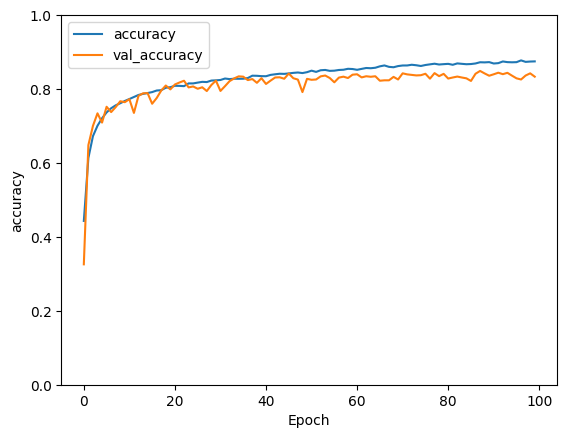

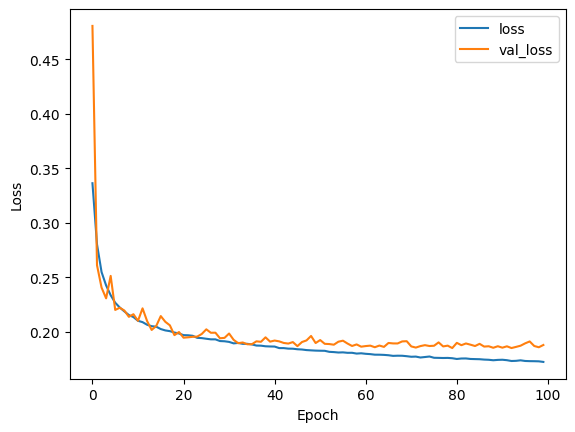

Model and weights are saved in separate files.


In [14]:
run_model()

In [111]:
emotions = ['neutre', 'bonheur', 'surprise', 'tristesse', 'colère', 'dégoût', 'peur']

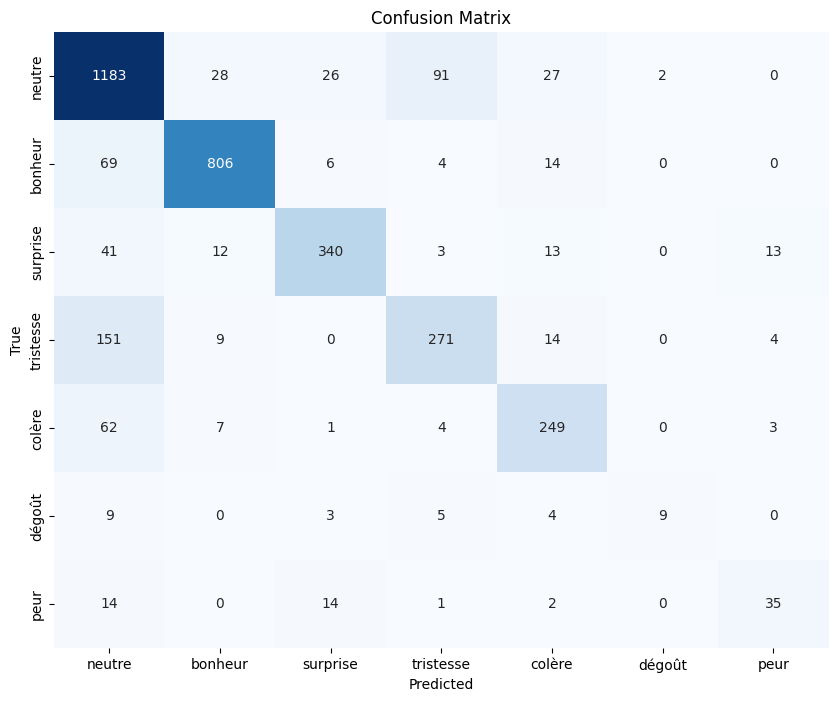

In [113]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Convertir les prédictions et les étiquettes en indices de classe
y_test_indices = np.argmax(y_test, axis=1)
predictions_indices = np.argmax(predictions, axis=1)

# Obtenez la matrice de confusion
conf_matrix = confusion_matrix(y_test_indices, predictions_indices)

# Affichez la matrice de confusion avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [114]:
# Affichez le rapport de classification
print("Classification Report:\n", classification_report(y_test_indices, predictions_indices, target_names=emotions))

Classification Report:
               precision    recall  f1-score   support

      neutre       0.77      0.87      0.82      1357
     bonheur       0.94      0.90      0.92       899
    surprise       0.87      0.81      0.84       422
   tristesse       0.72      0.60      0.65       449
      colère       0.77      0.76      0.77       326
      dégoût       0.82      0.30      0.44        30
        peur       0.64      0.53      0.58        66

    accuracy                           0.82      3549
   macro avg       0.79      0.68      0.72      3549
weighted avg       0.82      0.82      0.81      3549



In [126]:
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
import matplotlib.pyplot as plt

def facial_emotion_recognition(image_path):
    # Load model from JSON file
    json_file = open('/kaggle/input/mes-modeles/model8323.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # Load weights and them to model
    model.load_weights('/kaggle/input/mes-modeles/model8323.h5')

    classifier = cv2.CascadeClassifier('/kaggle/input/code-executable/haarcascade_frontalface_default.xml')

    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces_detected = classifier.detectMultiScale(gray_img, 1.18, 5)

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi_gray = gray_img[y:y + w, x:x + h]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)
        img_pixels /= 255.0

        predictions = model.predict(img_pixels)
        max_index = int(np.argmax(predictions))

        emotions = ['neutre', 'bonheur', 'surprise', 'tristesse', 'colere', 'degout', 'peur']
        predicted_emotion = emotions[max_index]

        cv2.putText(img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

    # Affichage de l'image avec le texte en utilisant Matplotlib
    print(predicted_emotion)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('Facial Emotion Recognition')
    plt.show()



1/1 [==============================] - 0s 193ms/step
neutre


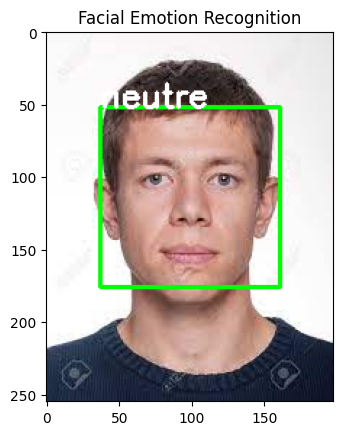

In [127]:
facial_emotion_recognition('/kaggle/input/pred-img/neutral1.jpg')

1/1 [==============================] - 0s 219ms/step
bonheur


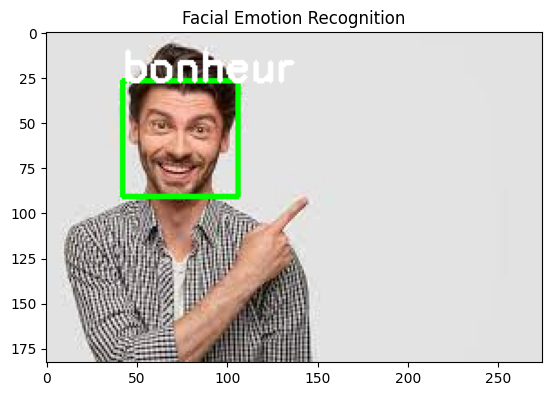

In [128]:
facial_emotion_recognition('/kaggle/input/pred-img/test1jpg.jpg')

1/1 [==============================] - 0s 202ms/step
surprise


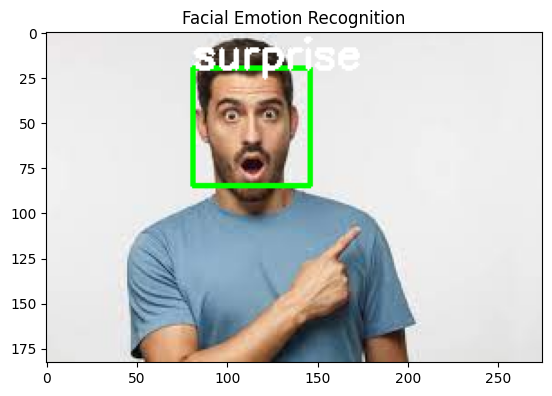

In [129]:
facial_emotion_recognition('/kaggle/input/pred-img/surprise.jpg')

1/1 [==============================] - 0s 218ms/step
tristesse


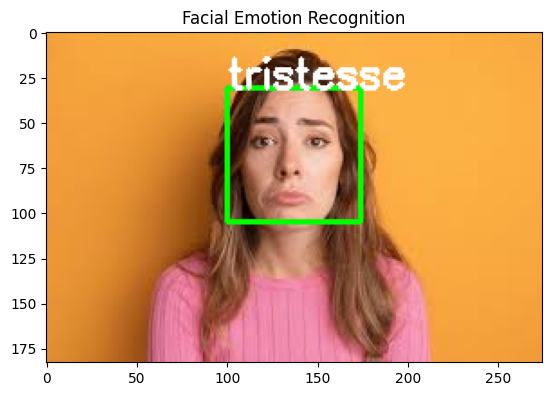

In [130]:
facial_emotion_recognition('/kaggle/input/pred-img/sad2.jpg')

1/1 [==============================] - 0s 209ms/step
colere


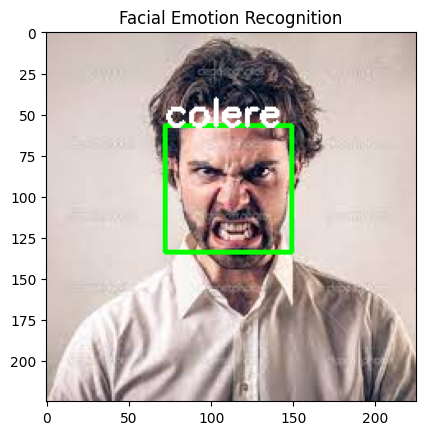

In [131]:
facial_emotion_recognition('/kaggle/input/pred-img/angrytest.jpg')

1/1 [==============================] - 0s 203ms/step
degout


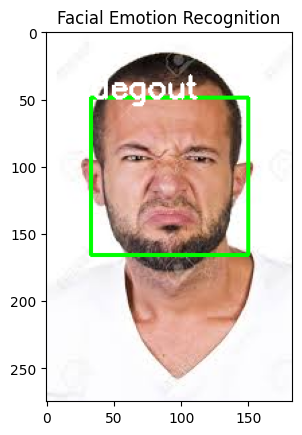

In [135]:
facial_emotion_recognition('/kaggle/input/degout-test/degou98e78326e.jpg')